#### SIADS 696 Milestone II

In [80]:
import pandas as pd
import numpy as np
from data_columns import childhood, demographic, diagnosis, all
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


In [81]:
init_df = pd.read_csv('./data/mental-health-comorbidity-raw.csv')
init_df.shape

(5001, 1000)

In [82]:
df = init_df[all()].copy()
# df = df.replace(-9, np.nan)
# df = df.dropna()
df.shape

(5001, 122)

In [83]:
columns2 = demographic() + childhood() + ['DSM_MJD']
num_columns = ["HHSIZE","AGE"] + ["CH13","CH14","CH16","CH21","CH22","CH24","CH38","CH43","CH45"]
child_df = df[columns2].copy()

child_df = child_df.replace(-9, np.nan)
child_df = child_df.dropna()

cat_columns = [col for col in child_df.columns if col not in num_columns]
child_df[cat_columns] = child_df[cat_columns].astype('category')
df[num_columns] = df[num_columns].astype(int)


In [84]:
X = child_df.drop(columns=['DSM_MJD'])
y = child_df['DSM_MJD']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.30      0.34      0.32       197
           5       0.83      0.81      0.82       795

    accuracy                           0.71       992
   macro avg       0.57      0.57      0.57       992
weighted avg       0.72      0.71      0.72       992



In [85]:
cat_columns = [col for col in cat_columns if col != 'DSM_MJD']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_columns),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_columns)
])

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier())
])


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.43      0.02      0.03       197
           5       0.80      0.99      0.89       795

    accuracy                           0.80       992
   macro avg       0.62      0.51      0.46       992
weighted avg       0.73      0.80      0.72       992



In [88]:
u_smpl = RandomUnderSampler(random_state = 42) 

X_u_smpl, y_u_smpl = u_smpl.fit_resample(X_train,y_train)

pipeline.fit(X_u_smpl, y_u_smpl)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.28      0.62      0.38       197
           5       0.86      0.60      0.71       795

    accuracy                           0.61       992
   macro avg       0.57      0.61      0.55       992
weighted avg       0.75      0.61      0.65       992



In [89]:
scores = cross_val_score(pipeline, X_u_smpl, y_u_smpl, cv=5,scoring="f1") 
print("Cross-validated scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validated scores: [0.58490566 0.66875    0.59627329 0.64848485 0.66066066]
Mean accuracy: 0.6318148922896667


<Axes: xlabel='DSM_MJD'>

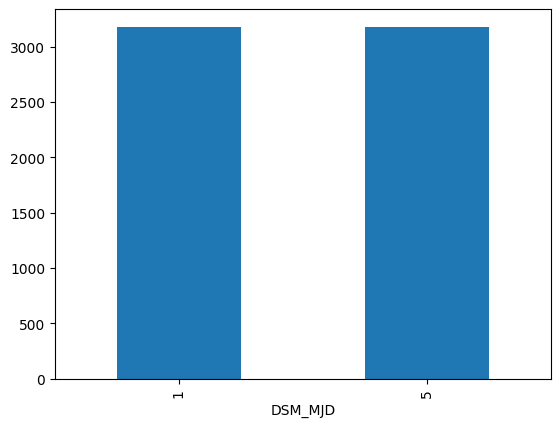

In [90]:
o_smpl = RandomOverSampler(random_state = 42) 
X_o_smpl, y_o_smpl = o_smpl.fit_resample(X_train,y_train)
y_o_smpl.value_counts().plot.bar()

In [91]:
pipeline.fit(X_o_smpl, y_o_smpl)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.38      0.05      0.09       197
           5       0.81      0.98      0.88       795

    accuracy                           0.80       992
   macro avg       0.60      0.52      0.49       992
weighted avg       0.72      0.80      0.73       992



In [92]:

scores = cross_val_score(pipeline, X_o_smpl, y_o_smpl, cv=5,scoring="f1") 
print("Cross-validated scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validated scores: [0.95207668 0.95461659 0.97918273 0.98299845 0.97546012]
Mean accuracy: 0.9688669144431028


<Axes: xlabel='DSM_MJD'>

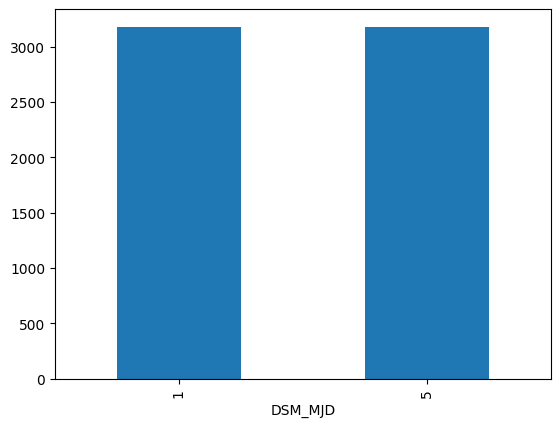

In [93]:
smote = SMOTE(random_state = 42) 
X_smote, y_smote = smote.fit_resample(X_train,y_train)

y_smote.value_counts().plot.bar()

In [94]:
pipeline.fit(X_smote, y_smote)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.75      0.02      0.03       197
           5       0.80      1.00      0.89       795

    accuracy                           0.80       992
   macro avg       0.78      0.51      0.46       992
weighted avg       0.79      0.80      0.72       992



In [95]:
scores = cross_val_score(pipeline, X_smote, y_smote, cv=5,scoring="f1") 
print("Cross-validated scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validated scores: [0.         0.86298932 0.9945184  0.99608457 0.99297424]
Mean accuracy: 0.7693133076887297


In [96]:
from imblearn.over_sampling import BorderlineSMOTE

bsmote = BorderlineSMOTE(random_state = 42) 

X_bsmote, y_bsmote = bsmote.fit_resample(X_train,y_train)
pipeline.fit(X_bsmote, y_bsmote)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.83      0.03      0.05       197
           5       0.81      1.00      0.89       795

    accuracy                           0.81       992
   macro avg       0.82      0.51      0.47       992
weighted avg       0.81      0.81      0.72       992

